# CS 429: Information Retrieval
<br>

## Clustering Words

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology
### Spring 2015

# Motivation

Often, we want to know which features appear together.

- If you liked *Twilight* you might like *Nosferatu*.
- "happy" is a synonym of "glad."

We'll use k-means to cluster together related words from Twitter.

**Caution:** This uses live Twitter data, which often contains profanity.

In [2]:
# Get some tweets containing the word 'i'.

import os
from TwitterAPI import TwitterAPI

# Read Twitter credentials from environmental variables.
api = TwitterAPI(os.environ.get('TW_CONSUMER_KEY'),
                 os.environ.get('TW_CONSUMER_SECRET'),
                 os.environ.get('TW_ACCESS_TOKEN'),
                 os.environ.get('TW_ACCESS_TOKEN_SECRET'))

# Collect 5000 tweets.
tweets = []
while True: 
    r = api.request('statuses/filter', {'track':'i',
                                      'language':'en'})
    if r.status_code != 200: # error
        break
    else:
        for item in r.get_iterator():
            tweets.append(item)
            if len(tweets) > 5000:
                break
            elif len(tweets) % 100 == 0:
                print(len(tweets))


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [3]:
print(len(tweets))

5003


In [4]:
# Each tweet is a Python dict.
print('text', tweets[0]['text'])
print('description:', tweets[0]['user']['description'])
print('name:', tweets[0]['user']['name'])
print('location:', tweets[0]['user']['location'])

text @Maddy_Valone thanks madelynn, I love you💖
description: actions speak louder than words// 10.23.15❤️ 03.07.16 AB❤️❤️
name: Tay
location: None


In [5]:
tweets = [t for t in tweets if 'text' in t]

In [6]:
len(tweets)

4623

In [7]:
# Tokenize each tweet text.
import re
tokens = []
for tweet in tweets:
    text = tweet['text'].lower()
    text = re.sub('@\S+', ' ', text)  # Remove mentions.
    text = re.sub('http\S+', ' ', text)  # Remove urls.
    tokens.append(re.findall('[A-Za-z]+', text)) # Retain words.
tokens[0]

['thanks', 'madelynn', 'i', 'love', 'you']

In [8]:
# Count words.
from collections import Counter

word_counts = Counter()
for tweet in tokens:
    word_counts.update(tweet)

In [9]:
# Inspect word counts.
import math

print(len(word_counts), 'unique terms')
word_counts.most_common(10)

7502 unique terms


[('i', 5702),
 ('rt', 1845),
 ('to', 1465),
 ('the', 1384),
 ('a', 1220),
 ('you', 1085),
 ('m', 964),
 ('and', 941),
 ('my', 884),
 ('t', 780)]

In [10]:
# Retain in vocabulary words occurring more than twice.
vocab = set([w for w, c in word_counts.items() if c > 1])
print('%d words occur at least two times.' % len(vocab))

3145 words occur at least two times.


In [11]:
# Prune tokens.
newtoks = []
for i, tweet in enumerate(tokens):
    newtok = [token for token in tweet if token in vocab]
    if len(newtok) > 0:
        newtoks.append(newtok)
tokens = newtoks

In [14]:
# A sample pruned tweet.
tokens[0]

['thanks', 'i', 'love', 'you']

In [15]:
# For each term, create a context vector, indicating how often
# each word occurs to the left or right of it.
from collections import defaultdict
import numpy as np

# dict from term to context vector.
contexts = defaultdict(lambda: Counter())
window = 2
for tweet in tokens:
    for i, token in enumerate(tweet):
        features = []
        for j in range(np.amax([0, i-window]), i):
            features.append(tweet[j] + "@" + str(j-i))
        for j in range(i+1, min(i + window, len(tweet))):
            features.append(tweet[j] + "@" + str(j-i))
        contexts[token].update(features)
        # Optionally: ignore word order
        # contexts[token].update(tweet[:i] + tweet[i+1:])


In [16]:
contexts['i'].most_common(20)

[('m@1', 949),
 ('rt@-1', 791),
 ('and@-1', 233),
 ('love@1', 219),
 ('ve@1', 209),
 ('can@1', 208),
 ('rt@-2', 201),
 ('don@1', 172),
 ('have@1', 169),
 ('just@1', 166),
 ('but@-1', 164),
 ('ll@1', 162),
 ('when@-1', 139),
 ('the@-2', 136),
 ('am@1', 134),
 ('was@1', 125),
 ('me@-2', 118),
 ('want@1', 110),
 ('i@-2', 109),
 ('hate@1', 106)]

In [17]:
# Compute the number of different contexts each term appears in.
tweet_freq = Counter()
for context in contexts.values():
    tweet_freq.update(context)
tweet_freq.most_common(5)

[('i@-1', 5675),
 ('i@-2', 5464),
 ('i@1', 4350),
 ('rt@-1', 1844),
 ('rt@-2', 1838)]

In [18]:
# Transform each context vector to be term freq / tweet frequency. 
# Also then normalize by length.
for term, context in contexts.items():
    for term2, frequency in context.items():
        context[term2] = frequency / (1. + math.log(tweet_freq[term2]))
    length = math.sqrt(sum([v*v for v in context.values()]))
    for term2, frequency in context.items():
        context[term2] = 1. * frequency / length
    
contexts['i'].most_common(5)

[('m@1', 0.6074600339659124),
 ('rt@-1', 0.46777716298830435),
 ('love@1', 0.16287334308387164),
 ('ve@1', 0.16207223522779549),
 ('and@-1', 0.14995192581405317)]

In [19]:
contexts['school'].most_common(10)

[('fake@-2', 0.5975239422063642),
 ('friends@-1', 0.5372074585396509),
 ('being@1', 0.4509488564161085),
 ('is@1', 0.15957649683887706),
 ('go@-2', 0.11810454155883642),
 ('rt@-1', 0.10816530593283122),
 ('to@-1', 0.09752316082466882),
 ('middle@-1', 0.08828866275699869),
 ('project@1', 0.0720574292682831),
 ('incident@-2', 0.06803418701026041)]

At this point we have a list of dictionaries, one per term, indicating the terms that co-occur (weighted by inverse tweet frequency).

Next, we have to cluster these vectors. To do this, we'll need to be able to compute the euclidean distance between two vectors.

In [20]:
# This is not efficient!
def distance(c1, c2):
    if len(c1.keys()) == 0 or len(c2.keys()) == 0:
        return 1e9
    keys = set(c1.keys()) | set(c2.keys())
    distance = 0.
    for k in keys:
        distance += (c1[k] - c2[k]) ** 2
    return math.sqrt(distance)

print(distance({'hi':10, 'bye': 5}, {'hi': 9, 'bye': 4}))
print(distance({'hi':10, 'bye': 5}, {'hi': 8, 'bye': 4}))

1.4142135623730951
2.23606797749979


In [21]:
def find_closest(term, n=5):
    terms = np.array(list(contexts.keys()))
    context = contexts[term]
    distances = []
    for term2, context2 in contexts.items():
        distances.append(distance(context, context2))
    return terms[np.argsort(distances)][:n]

find_closest('love', n=10)

array(['love', 'hope', 'miss', 'm', 'swear', 'am', 'll', 'bet', 've',
       'hate'], 
      dtype='<U22')

In [22]:
nz_contexts = [t for t, context in contexts.items()
               if len(context) > 1]
contexts = dict([(term, contexts[term]) for term in nz_contexts])
print(len(nz_contexts), 'nonzero contexts')

3143 nonzero contexts


In [23]:
# Transform context dicts to a sparse vector
# for sklearn.
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
X = vec.fit_transform(contexts.values())
names = np.array(vec.get_feature_names())
print(names[:10])
print(X[0])

['a@-1' 'a@-2' 'a@1' 'abgehakt@-1' 'abgehakt@-2' 'abgehakt@1' 'abi@1'
 'ability@-1' 'ability@-2' 'ability@1']
  (0, 2730)	0.356687862264
  (0, 5155)	0.660034013128
  (0, 6855)	0.238859146112
  (0, 7255)	0.425839590179
  (0, 8208)	0.207871150335
  (0, 8237)	0.394367096803


In [36]:
# Which row of X is the word "love"?
love_idx = list(contexts.keys()).index('love')
print(love_idx)
# What are the context feature values for love?
print(X[love_idx])
# Print a highly ranking feature.
print(names[9171])

828
  (0, 1)	0.00477244645424
  (0, 2)	0.00940532605072
  (0, 15)	0.00614343176802
  (0, 74)	0.00835941470593
  (0, 79)	0.0181453447983
  (0, 138)	0.00729571555916
  (0, 177)	0.00841294973494
  (0, 201)	0.0422557059747
  (0, 230)	0.00886440634587
  (0, 244)	0.00679373548211
  (0, 246)	0.00681831071018
  (0, 251)	0.0201877524318
  (0, 268)	0.00629437188756
  (0, 269)	0.0190704309034
  (0, 274)	0.00972830351336
  (0, 275)	0.029380834053
  (0, 276)	0.00974457462836
  (0, 400)	0.0104642604187
  (0, 465)	0.00650715082774
  (0, 548)	0.0181453447983
  (0, 590)	0.0180522229886
  (0, 591)	0.00920809982738
  (0, 631)	0.022490687173
  (0, 731)	0.00704309616134
  (0, 762)	0.0129629837028
  :	:
  (0, 8846)	0.022490687173
  (0, 8853)	0.0292866721661
  (0, 8864)	0.00993423536806
  (0, 8876)	0.006409009642
  (0, 8897)	0.00679373548211
  (0, 8911)	0.0186546052707
  (0, 8912)	0.012498065172
  (0, 8913)	0.00620620836335
  (0, 8963)	0.00566090463241
  (0, 8964)	0.0387255296187
  (0, 8970)	0.00941521382615

In [37]:
# Let's cluster!
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans
num_clusters = 20
kmeans = KMeans(num_clusters)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [38]:
# Let's print out the top features for each mean vector.
# This is swamped by common terms
for i in range(num_clusters):
    print(i, ' '.join(names[np.argsort(kmeans.cluster_centers_[i])[::-1][:5]]))

0 to@-1 t@-1 i@-1 i@-2 me@1
1 and@1 rt@-1 i@1 of@-1 to@-2
2 the@-1 i@1 and@1 a@-1 in@-2
3 and@-1 i@1 to@-1 in@1 the@1
4 m@-2 so@-1 i@-2 not@-1 m@-1
5 the@-2 i@1 and@1 a@-1 most@-1
6 it@-1 like@1 that@-1 to@1 the@1
7 the@-1 in@-2 i@1 of@1 for@-2
8 i@-1 rt@-2 i@-2 t@1 a@1
9 my@-1 and@1 to@-2 your@-1 i@1
10 it@-2 do@-2 s@-1 but@-1 art@1
11 an@-1 for@1 in@-2 i@1 of@-2
12 a@-2 i@1 i@-2 in@-1 the@-1
13 of@1 a@-1 the@-1 i@-2 the@-2
14 to@1 i@-2 i@-1 to@-1 m@-1
15 and@-2 i@-1 the@1 it@1 for@-1
16 i@-2 i@-1 ve@-1 just@-1 in@1
17 i@1 rt@-1 i@-2 to@-2 me@-1
18 i@-2 m@-1 i@1 be@-1 the@1
19 a@-1 i@1 and@1 have@-2 in@-2


In [40]:
# .transform will compute the distance from each context to each cluster.
distances = kmeans.transform(X)
distances[0]

array([ 1.07242557,  0.99899023,  1.02986095,  1.02875689,  1.06510437,
        1.02811637,  1.0538714 ,  1.14194475,  1.12543407,  1.06321653,
        1.02268792,  1.07671936,  1.01856784,  1.08200541,  1.01522164,
        1.04871631,  1.04493059,  1.04957583,  1.10209854,  1.05484867])

In [41]:
# Finally, we'll print the words that are closest
# to the mean of each cluster.
terms = np.array(list(contexts.keys()))
for i in range(num_clusters):
    print(i, ' '.join(terms[np.argsort(distances[:,i])[1:10]]), '\n')

0 see do make say sleep hear be tell know 

1 me like and you that work this a on 

2 same sky fact finale world freezer bathroom ground couch 

3 families bea sliding hug dang yup taylor cristal protein 

4 thankful excited grateful glad bummed pissed bored tired much 

5 person thing ensure bell vlogs time record cl of 

6 tooo feels seems bby takes looks bringing doc upstairs 

7 best sky finale world fact freezer bathroom ground res 

8 love swear am miss ll ve have just was 

9 life ability boyfriend countrymen son ear sister parents fault 

10 whatever wrong bigger cold bea within prolly magic fails 

11 argument hour interpreter attitude athlete audition era article outspoken 

12 from photo cs of sending mother bowl town boy 

13 type bunch ton member perk part plenty bottle piece 

14 trying listening supposed able listen tend want embarrassed tryin 

15 freaked petty votes keeping arguing cant making among loads 

16 a never crossing you finished curious received witnessed st

Clearly, interpreting these results requires a bit of investigation.

Some patterns do emerge:
 - Cluster 7 has Polish
 - Cluster 8 are about communication acts
 - Cluster 13 is family
 - Cluster 14 seems to be abbreviations/[disfluencies](http://en.wikipedia.org/wiki/Speech_disfluency)

As the number of tweets increases, we expect these clusters to become more coherent.

**How does error decrease with number of cluster?**

In [43]:
kmeans.score(X)

-2857.5917288226187

k=5 score=2970.76
k=10 score=2907.65
k=20 score=2859.23
k=50 score=2774.11
k=100 score=2686.25


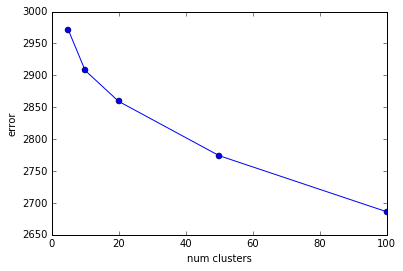

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

scores = []
num_cluster_options = [5,10,20,50,100]

for num_clusters in num_cluster_options:
    kmeans = KMeans(num_clusters, n_init=10, max_iter=10)
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print('k=%d score=%g' % (num_clusters, score))
    
plt.figure()
plt.plot(num_cluster_options, scores, 'bo-')
plt.xlabel('num clusters')
plt.ylabel('error')
plt.show()

** How does error vary by initalization? **

score=2866.97
score=2860.65
score=2868.09
score=2866.2
score=2882.51
score=2863.72
score=2859.34
score=2867.88
score=2883.09
score=2869.8


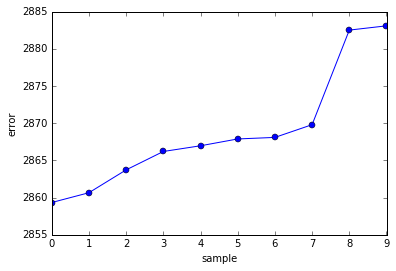

In [46]:
scores = []
for i in range(10):
    kmeans = KMeans(20, n_init=1, max_iter=100, init='random')
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print('score=%g' % (score))
     
    
plt.figure()
plt.plot(range(10), sorted(scores), 'bo-')
plt.xlabel('sample')
plt.ylabel('error')
plt.show()